#Hybrid-Movie-Recommender system

Most movie recommender system mostly rely on user rating data to predict user ratings and give recommendations. However, the problem is that most movie recommender systems only leverage user data and item data for collaborative filtering. In this following notebook, we will try to implement a neural network that predicts user rating based on
1. User metadata
2. Item metadata
3. Rating matrix

All of our training data was prepared in **Hybrid-Movie-Recommender-Data-Processing**  notebook. Our job is to now combine each user and movie features for predicting ratings

In [1]:
#mount driver with data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install seaborn==0.9.0

In [3]:
# import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten, Activation, Reshape, Input
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
import keras.backend as K

Using TensorFlow backend.


In [0]:
#fetch data
final_user_features=np.load("/content/gdrive/My Drive/Colab Notebooks/movieRec/data/user_features.npy")
final_movie_features=np.load("/content/gdrive/My Drive/Colab Notebooks/movieRec/data/movie_features.npy")
labels = np.load("/content/gdrive/My Drive/Colab Notebooks/movieRec/data/labels.npy")

##Model construction

The model will take seperate inputs from user and movie features and use DNN to throttle both user/movie features into smaller dimensions through NN. Afterwards, these two embedding (reduced features) will be concatenated and fed into a single DNN for ratings prediction.

In [5]:
#take user input and condense it down to 50 dimensions using NN
user_input = Input(shape=(106,),name='user_input')
u = Dense(units=75,activation='relu')(user_input)
u = BatchNormalization()(u)
u = Dropout(0.5)(u)
u = Dense(units=75,activation='relu')(u)
u = BatchNormalization()(u)
u = Dropout(0.5)(u)
u = Dense(units=75,activation='relu')(u)
u = BatchNormalization()(u)
u = Dropout(0.5)(u)
user_embedding = Dense(units=50,activation='relu')(u)

#take movie input and condense it down to 25 dimensions using NN
movie_input = Input(shape=(54,),name='movie_input')
m = Dense(units=40,activation='relu')(movie_input)
m = BatchNormalization()(m)
m = Dropout(0.5)(m)
m = Dense(units=40,activation='relu')(m)
m = BatchNormalization()(m)
m = Dropout(0.5)(m)
m = Dense(units=40,activation='relu')(m)
m = BatchNormalization()(m)
m = Dropout(0.5)(m)
movie_embedding = Dense(units=40,activation='relu')(m)

#concat both user and movie embeddings and stack a NN for computation
combined_input = keras.layers.concatenate([user_embedding,movie_embedding])
x = Dense(units=75,activation='relu')(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(units=50,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(units=25,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(units=25,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(units=15,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(units=1,activation='relu')(x)

model = Model(inputs=[user_input,movie_input],outputs=[output])
optimizer = Adam(lr=0.00001)
#custom rmse metrics
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred-y_true)))
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae',rmse])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 106)          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        (None, 54)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 75)           8025        user_input[0][0]                 
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 40)           2200        movie_input[0][0]                
__________________________________________________________________________________________________
batch_norm

In [0]:
from sklearn.model_selection import train_test_split

#split data into train and test set
train_user, test_user, train_movie, test_movie, y_train, y_test = train_test_split(final_user_features,final_movie_features,labels,test_size=0.2)

In [7]:
#train and save result to history for evaluation.
history = model.fit([train_user,train_movie],[y_train],epochs=50, batch_size=256,shuffle=True,validation_data=([test_user,test_movie], [y_test]))

Train on 800167 samples, validate on 200042 samples
Epoch 1/50
800167/800167 [==============================] - 134s 167us/step - loss: 10.6148 - mean_absolute_error: 2.9559 - rmse: 3.2567 - val_loss: 10.2695 - val_mean_absolute_error: 2.9943 - val_rmse: 3.2040
Epoch 2/50
800167/800167 [==============================] - 129s 161us/step - loss: 9.5979 - mean_absolute_error: 2.7672 - rmse: 3.0967 - val_loss: 6.3813 - val_mean_absolute_error: 2.2948 - val_rmse: 2.5255
Epoch 3/50
800167/800167 [==============================] - 128s 161us/step - loss: 8.6400 - mean_absolute_error: 2.5790 - rmse: 2.9381 - val_loss: 3.4575 - val_mean_absolute_error: 1.6306 - val_rmse: 1.8587
Epoch 4/50
800167/800167 [==============================] - 129s 161us/step - loss: 7.7219 - mean_absolute_error: 2.3920 - rmse: 2.7774 - val_loss: 2.0604 - val_mean_absolute_error: 1.2328 - val_rmse: 1.4347
Epoch 5/50
800167/800167 [==============================] - 129s 162us/step - loss: 6.8660 - mean_absolute_error: 

## Evaluating the model

Lastly, let us check how the training and validation loss performed during the training process.

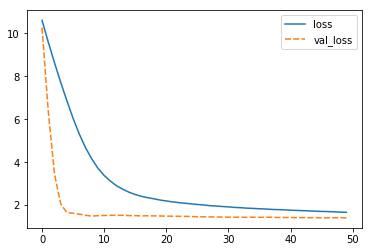

In [8]:
import seaborn as sns
history = pd.DataFrame(history.history)
sns.lineplot(data=history[['loss','val_loss']])

Overall, the optimization process seems to be going quite well with both validation and training loss going down together. However, it seems to reach a converging point pretty fast

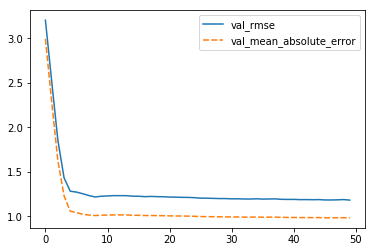

In [9]:
sns.lineplot(data=history[['val_rmse','val_mean_absolute_error']])

In terms of validation loss, it seems that MAE indicates quite a good performance with lower than 1.0 threshold. Since we are on a 5 star scale, the results are not as impressive as we expected. Perhaps some hyperparameter tuning or increasing the PCA dimenions to use larger embedding for better representation of rating data. From the graphs, increasing number of epochs wouldn't help the model too much either. However, it is important to note that this hybrid model structure is definately workable solution for recommendation engine.